In [11]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
images = glob.glob('/kaggle/input/brain-tumor-segmentation/images/*')
masks = glob.glob('/kaggle/input/brain-tumor-segmentation/masks/*')

In [3]:
print(len(images))
print(len(masks))

3064
3064


In [4]:
preprocess_images = []
for img in images:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    image = image / 255.0
    preprocess_images.append(image)

In [5]:
preprocess_masks = []
for mask in masks:
    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask / 255.0
    preprocess_masks.append(mask)

In [6]:
X = np.array(preprocess_images, dtype=np.float32)

preprocess_masks = np.array(preprocess_masks, dtype=np.float32)
preprocess_masks = np.expand_dims(preprocess_masks, axis=-1)  
preprocess_masks = (preprocess_masks > 0.5).astype(np.int32)  

y = preprocess_masks

In [7]:
print(X.shape)
print(y.shape)

(3064, 256, 256, 3)
(3064, 256, 256, 1)


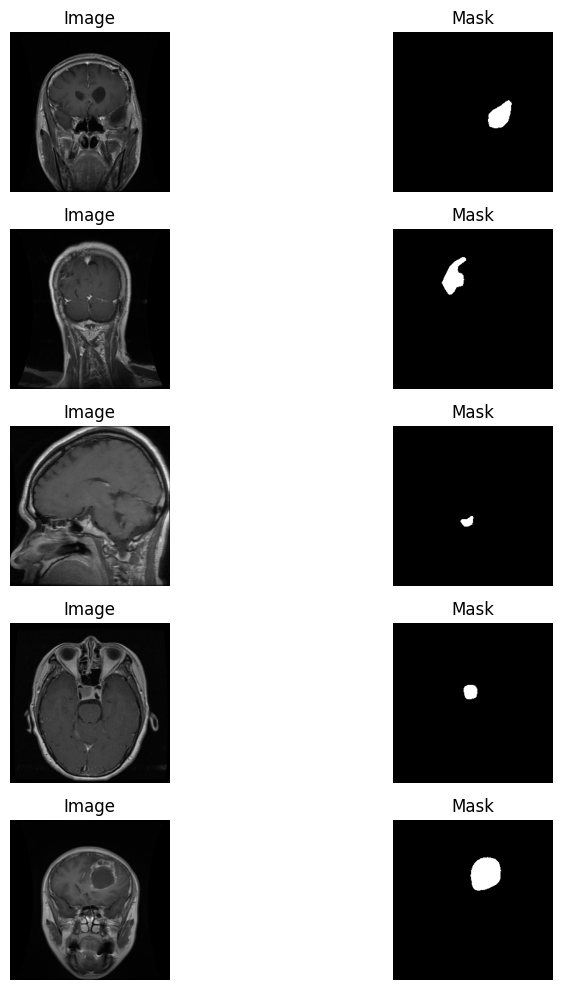

In [23]:
num_samples = 5

plt.figure(figsize=(10, 10))

for i in range(num_samples):
    plt.subplot(num_samples, 2, i * 2 + 1)
    plt.imshow(X[i])
    plt.title("Image")
    plt.axis("off")
    
    plt.subplot(num_samples, 2, i * 2 + 2)
    plt.imshow(y[i], cmap='gray')  
    plt.title("Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
def conv_block(x, filters, kernel_size=3, activation=None, padding='same'):
    """(Conv2D -> BN -> Activation) * 2 block."""
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)  # Use LeakyReLU explicitly

    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)  # Use LeakyReLU explicitly
    return x

def encoder_block(x, filters, activation='relu'):
    """Encoder block: conv block + maxpool."""
    c = conv_block(x, filters, activation=activation)
    p = MaxPool2D((2, 2))(c)
    return c, p

def decoder_block(x, skip_features, filters, activation='relu'):
    """Decoder block: transpose conv + concat + conv block."""
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filters, activation=activation)
    return x

def build_beefy_unet(input_shape=(256, 256, 3), activation='relu'):
    """Build a beefed-up UNet with batch normalization and double conv blocks."""
    inputs = Input(input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, 64, activation=activation)
    c2, p2 = encoder_block(p1,   128, activation=activation)
    c3, p3 = encoder_block(p2,   256, activation=activation)
    c4, p4 = encoder_block(p3,   512, activation=activation)

    # Bottleneck
    bn = conv_block(p4, 1024, activation=activation)

    # Decoder
    d1 = decoder_block(bn, c4, 512, activation=activation)
    d2 = decoder_block(d1, c3, 256, activation=activation)
    d3 = decoder_block(d2, c2, 128, activation=activation)
    d4 = decoder_block(d3, c1, 64,  activation=activation)

    # Output
    outputs = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(d4)

    model = Model(inputs, outputs)
    return model

In [29]:
model = build_beefy_unet()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 256, 256,  │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 128,  │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 128, 128,  │    147,584 │ leaky_re_lu_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_7[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_37[0][0] 

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [30]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')  
    y_pred = K.cast(y_pred, 'float32')  
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [31]:
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient, iou_metric])

In [32]:
history = model.fit(X_train, y_train, batch_size=16, epochs=20, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - dice_coefficient: 0.1182 - iou_metric: 0.0641 - loss: 0.8818 - val_dice_coefficient: 0.0330 - val_iou_metric: 0.0168 - val_loss: 0.9670 - learning_rate: 0.0010
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - dice_coefficient: 0.4091 - iou_metric: 0.2612 - loss: 0.5909 - val_dice_coefficient: 8.7777e-04 - val_iou_metric: 4.5675e-04 - val_loss: 0.9991 - learning_rate: 0.0010
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - dice_coefficient: 0.4861 - iou_metric: 0.3250 - loss: 0.5139 - val_dice_coefficient: 0.0156 - val_iou_metric: 0.0079 - val_loss: 0.9843 - learning_rate: 0.0010
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - dice_coefficient: 0.5352 - iou_metric: 0.3695 - loss: 0.4648 - val_dice_coefficient: 0.1174 - val_iou_metric: 0.0626 - val_loss: 0.8826 - learning_rate: 0.0010
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - dice_coefficient: 0.5616 - iou_metric: 0.3939 - loss: 0.4384 - val_dice_coeff

In [34]:
loss, dice, iou = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Dice Coefficient: {dice}")
print(f"IoU: {iou}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 706ms/step - dice_coefficient: 0.7554 - iou_metric: 0.6088 - loss: 0.2450
Test Loss: 0.2587909400463104
Dice Coefficient: 0.7463099956512451
IoU: 0.5985470414161682


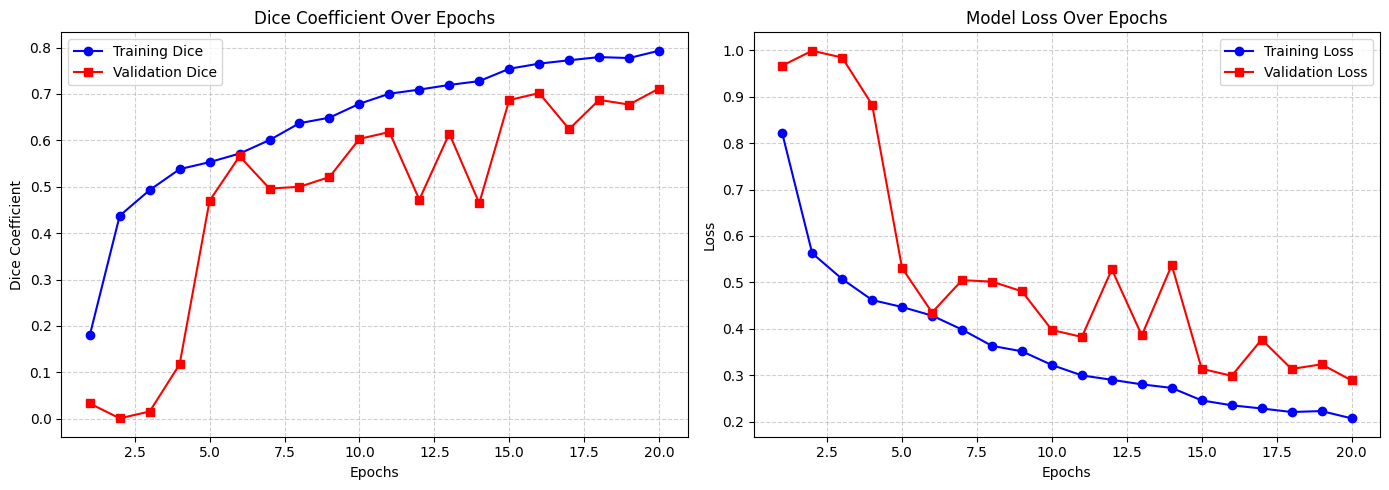

In [36]:
epochs = range(1, len(history.history['dice_coefficient']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['dice_coefficient'], 'b-o', label='Training Dice')
plt.plot(epochs, history.history['val_dice_coefficient'], 'r-s', label='Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient Over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'b-o', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r-s', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 810ms/step


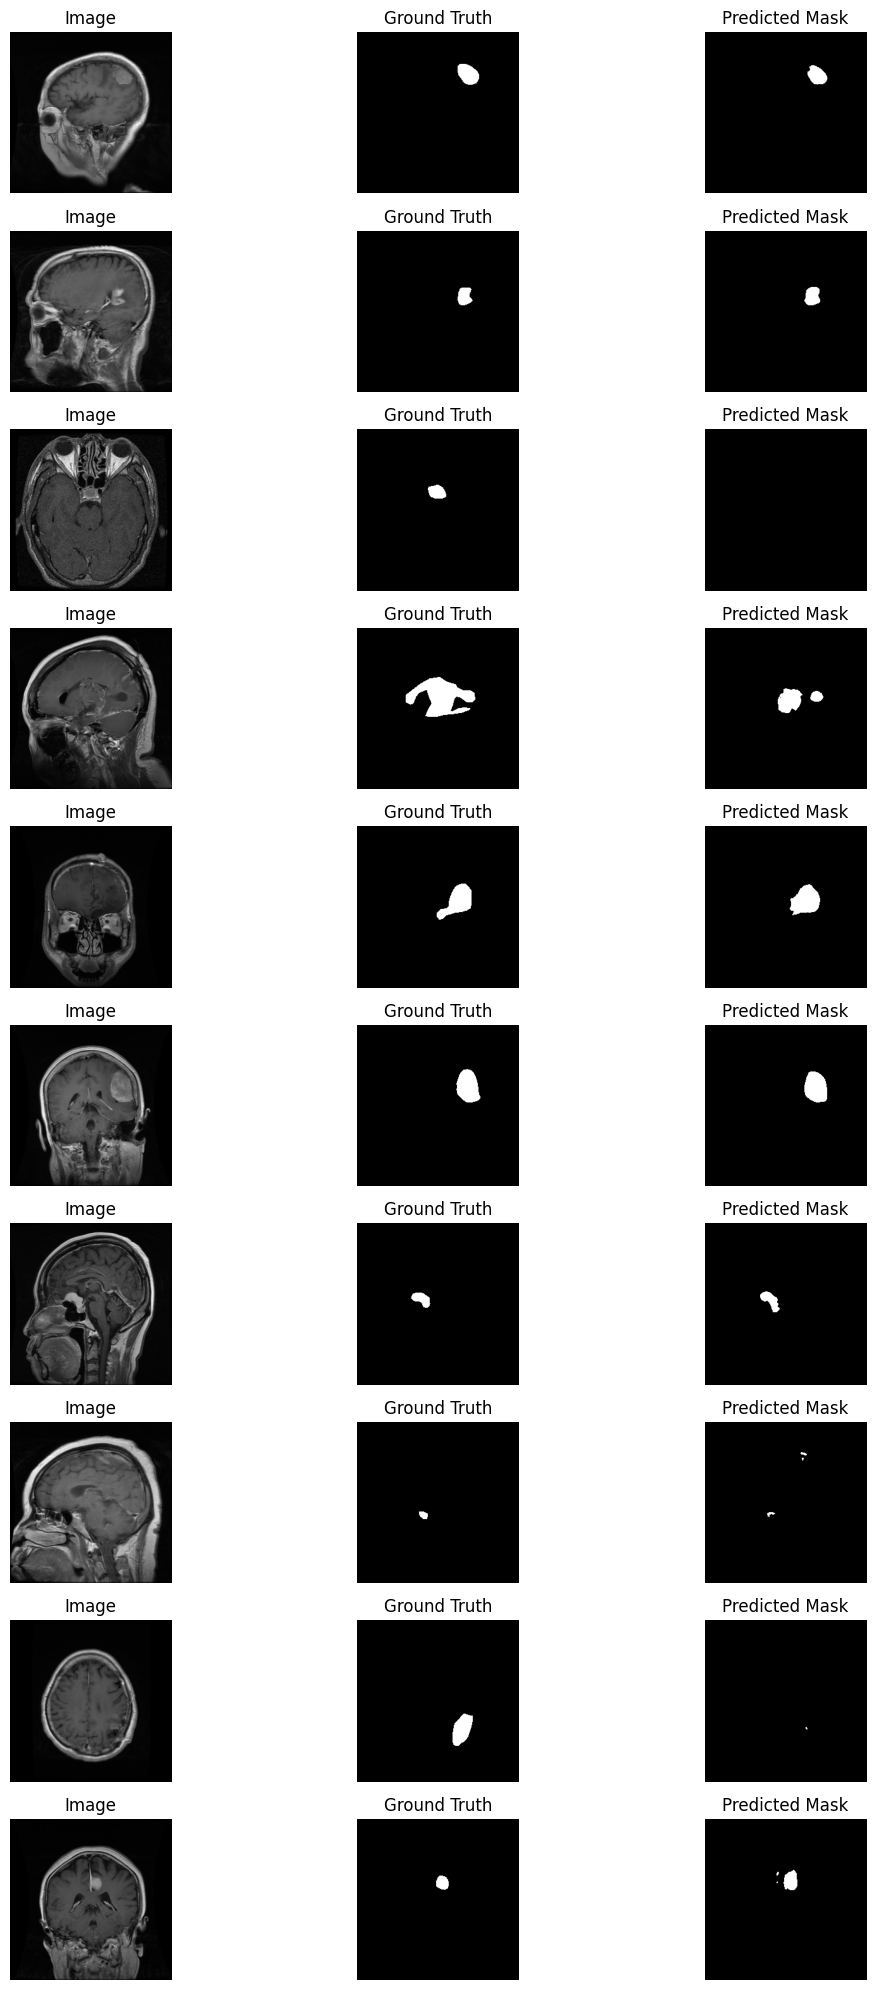

In [37]:
y_pred = model.predict(X_test)

y_pred_thresh = (y_pred > 0.5).astype(np.uint8)

num_samples = 10

plt.figure(figsize=(12, num_samples * 2))

for i in range(num_samples):
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(X_test[i])
    plt.title("Image")
    plt.axis("off")
    
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(y_test[i], cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")
    
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(y_pred_thresh[i], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()